# DGL-24 Kaggle Competition

In [1]:
import pandas as pd
from MatrixVectorizer import MatrixVectorizer
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import random
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import torch
import networkx as nx
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import psutil

from model import *
from preprocessing import *

# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')

mv = MatrixVectorizer()

IN_DIM = 160
OUT_DIM = 268

In [2]:
lr_train = pd.read_csv('./dgl-icl/lr_train.csv')
lr_test = pd.read_csv('./dgl-icl/lr_test.csv')
hr_train = pd.read_csv('./dgl-icl/hr_train.csv')

lr_train_tensor = torch.stack([torch.from_numpy(mv.anti_vectorize(lr_train.iloc[lr].to_numpy(), IN_DIM)) for lr in range(lr_train.shape[0])]).float()
hr_train_tensor = torch.stack([torch.from_numpy(mv.anti_vectorize(hr_train.iloc[lr].to_numpy(), OUT_DIM)) for lr in range(hr_train.shape[0])]).float()
lr_test_tensor = torch.stack([torch.from_numpy(mv.anti_vectorize(lr_test.iloc[lr].to_numpy(), IN_DIM)) for lr in range(lr_test.shape[0])]).float()

# X_tr_feats = np.load('./lr_train_centrality.npy')
# X_te_feats = np.load('./lr_test_centrality.npy')

In [3]:
# Attempt to add a feature vector matrix, not currently used
def build_feature_vector(A):
    G = nx.from_numpy_array(A.numpy())
    U = G.to_undirected()

    dc = nx.degree_centrality(U)
    degree_centrality = np.array([dc[g] for g in U])

    cc = nx.closeness_centrality(U, distance="weight")
    closeness_centrality = np.array([cc[g] for g in U])

    bc = nx.betweenness_centrality(U, weight='weight')
    betweenness_centrality = np.array([bc[g] for g in U])

    ec = nx.eigenvector_centrality_numpy(U)
    eigenvector_centrality = np.array([ec[g] for g in U])

    return np.stack([closeness_centrality, betweenness_centrality, eigenvector_centrality, degree_centrality], axis=1)

In [4]:
def compute_losses(model_outputs, hr, padding, net_outs, start_gcn_outs, weights, lmbda):
    criterion = nn.MSELoss()

    model_outputs = unpad(model_outputs, padding)

    pad_hr = pad_HR_adj(hr, padding)
    _, U_hr = torch.linalg.eigh(pad_hr)

    # Total loss = lambda * self_reconstruction_loss + eigenvalue_loss + super-resolution_loss
    L_rec = criterion(net_outs, start_gcn_outs)
    L_eig = criterion(weights, U_hr)
    L_hr = criterion(model_outputs, hr)
    # L_kl = (1/350) * F.kl_div(F.softmax(net_outs), F.softmax(start_gcn_outs), reduction='sum')
    loss = L_hr + L_eig + lmbda * L_rec

    return loss, L_hr, L_eig, L_rec

In [5]:
def collect_evaluation_stats(lr_test, hr_test, model):
    model.eval()
    mae_bc = []
    mae_ec = []
    mae_pc = []
    all_hr_pred = np.zeros((lr_test.shape[0], OUT_DIM, OUT_DIM))
    hr_test = hr_test.numpy()

    for i in range(lr_test.shape[0]):
        hr_pred = unpad(model(lr_test[i])[0].detach().fill_diagonal_(0).numpy(), 26)
        hr_gt = hr_test[i]

        pred_graph = nx.from_numpy_array(hr_pred)
        gt_graph = nx.from_numpy_array(hr_gt)

        pred_bc = list(nx.betweenness_centrality(pred_graph, weight="weight").values())
        pred_ec = list(nx.eigenvector_centrality(pred_graph, weight="weight").values())
        pred_pc = list(nx.pagerank(pred_graph, weight="weight").values())

        gt_bc = list(nx.betweenness_centrality(gt_graph, weight="weight").values())
        gt_ec = list(nx.eigenvector_centrality(gt_graph, weight="weight").values())
        gt_pc = list(nx.pagerank(gt_graph, weight="weight").values())

        mae_bc.append(mean_absolute_error(pred_bc, gt_bc))
        mae_ec.append(mean_absolute_error(pred_ec, gt_ec))
        mae_pc.append(mean_absolute_error(pred_pc, gt_pc))

        all_hr_pred[i] = hr_pred

    pred_1d = MatrixVectorizer.vectorize(all_hr_pred).flatten()
    gt_1d = MatrixVectorizer.vectorize(hr_test).flatten()

    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    avg_mae_bc = np.mean(mae_bc)
    avg_mae_ec = np.mean(mae_ec)
    avg_mae_pc = np.mean(mae_pc)

    # print("MAE: ", mae)
    # print("PCC: ", pcc)
    # print("Jensen-Shannon Distance: ", js_dis)
    # print("Average MAE betweenness centrality:", avg_mae_bc)
    # print("Average MAE eigenvector centrality:", avg_mae_ec)
    # print("Average MAE PageRank centrality:", avg_mae_pc)

    return {
        "MAE": mae,
        "PCC": pcc,
        "JSD": js_dis,
        "MAE (BC)": avg_mae_bc,
        "MAE (EC)": avg_mae_ec,
        "MAE (PC)": avg_mae_pc
    }


In [6]:
# Attempt to do data augmentation, not currently used
def augment_data_by_permutations(lr, hr):
    """
    Add n random permutations of each graph to the training data
    """
    lr = torch.cat([lr, torch.stack([lr[i].index_select(0, torch.randperm(IN_DIM)) for i in range(lr.shape[0])])])

    hr = torch.cat([hr, hr])
    return lr, hr

In [7]:
def eval_model(model, lrs, hrs, args):
    """
    Return the mean MAE of the predictions
    """
    model.eval()
    padding = args['padding']
    with torch.no_grad():
        MAEs = []
        
        for (lr, hr) in zip(lrs, hrs):
            model_outputs, _, _, _ = model(lr)
            model_outputs = unpad(model_outputs, padding)
            MAEs.append(np.abs(hr - model_outputs).mean())
    return np.mean(MAEs)

In [8]:
def create_submission_csv(X_test, model, file_name):
    model.eval()
    vectors = []

    for i in range(X_test.shape[0]):
        Xhat = unpad(model(X_test[i])[0].detach().fill_diagonal_(0).numpy(), 26)
        Xhat = np.where((Xhat < 0.0), 0.0, Xhat)
        Xhat = np.where((Xhat > 1.0), 1.0, Xhat)
        vectors += list(mv.vectorize(Xhat))

    df = pd.DataFrame(vectors, columns=['Predicted'])
    df.index.names = ['ID']
    df.index += 1
    df.to_csv(f'{file_name}.csv')

In [9]:
def train_model_adversarial(lr_train, hr_train, train_args, lr_val=None, hr_val=None, fold=None):
    n_epochs = train_args['epochs']
    lmbda = train_args['lambda']
    device = train_args['device']
    padding = train_args['padding']

    model = GSRNet(train_args).to(device)
    optimiser = torch.optim.Adam(model.parameters(), lr=train_args['lr'])

    discriminator = Discriminator(train_args['hr_dim']).to(device)
    optimiser_discriminator = torch.optim.Adam(discriminator.parameters(), lr=train_args['lr']) 
    
    for epoch in range(n_epochs):
        model.train()
        discriminator.train()

        train_loss, train_error, gen_losses = [], [], []

        for lr, hr in zip(lr_train, hr_train):
            lr, hr = lr.to(device), hr.to(device)
            if train_args['permutate_graph']:
                lr = lr.index_select(0, torch.randperm(train_args['lr_dim']))
            
            optimiser.zero_grad()
            optimiser_discriminator.zero_grad()

            model_outputs, net_outs, start_gcn_outs, _ = model(lr)
        
            loss, L_hr, _, _ = compute_losses(model_outputs, hr, padding, net_outs, start_gcn_outs, model.layer.weights, lmbda)

            padded_hr = pad_HR_adj(hr, padding)

            real_data, fake_data = model_outputs.detach(), generate_gaussian_noise(padded_hr)
            d_real, d_fake = discriminator(real_data), discriminator(fake_data)

            discriminator_loss = nn.BCELoss()(d_real, torch.ones(train_args['hr_dim'], 1)) + nn.BCELoss()(d_fake, torch.zeros(train_args['hr_dim'], 1))
            discriminator_loss.backward()
            optimiser_discriminator.step()

            d_fake = discriminator(generate_gaussian_noise(padded_hr))
            gen_loss = nn.BCELoss()(d_fake, torch.ones(train_args['hr_dim'], 1))
            
            generator_loss = gen_loss + loss
            generator_loss.backward()
            optimiser.step()

            train_loss.append(loss.item())
            train_error.append(L_hr.item())
            gen_losses.append(gen_loss.item())

        if lr_val is not None:
            val_mae = eval_model(model, lr_val, hr_val, train_args)
            print(f"Fold: {fold + 1}, Epoch: {epoch + 1}, Training Loss: {np.mean(train_loss):.4e}, Training Error: {np.mean(train_error):.4e}, Generator Loss: {np.mean(gen_losses):.4e}, Validation MAE: {val_mae:.4e}")
        else:
            print(f"Epoch: {epoch + 1}, Training Loss: {np.mean(train_loss):.4e}, Training Error: {np.mean(train_error):.4e}, Generator Loss: {np.mean(gen_losses):.4e}")
    return model

In [10]:
def train_model(lr_train, hr_train, train_args, lr_val=None, hr_val=None, fold=None):
    if train_args['data_augment']:
        lr_train, hr_train = augment_data_by_permutations(lr_train, hr_train)

    if train_args['adversarial']:
        return train_model_adversarial(lr_train, hr_train, train_args, lr_val, hr_val, fold)
    
    n_epochs = train_args['epochs']
    lmbda = train_args['lambda']
    device = train_args['device']
    padding = train_args['padding']

    model = GSRNet(train_args).to(device)
    optimiser = torch.optim.Adam(model.parameters(), lr=train_args['lr'])
    
    for epoch in range(n_epochs):
        model.train()

        train_loss = []
        train_error = []

        for lr, hr in zip(lr_train, hr_train):
            lr, hr = lr.to(device), hr.to(device)
            if train_args['permutate_graph']:
                lr = lr.index_select(0, torch.randperm(train_args['lr_dim']))
            
            model.train()
            optimiser.zero_grad()

            model_outputs, net_outs, start_gcn_outs, _ = model(lr)
        
            loss, L_hr, _, _ = compute_losses(model_outputs, hr, padding, net_outs, start_gcn_outs, model.layer.weights, lmbda)

            loss.backward()
            optimiser.step()

            train_loss.append(loss.item())
            train_error.append(L_hr.item())

        if lr_val is not None:
            val_mae = eval_model(model, lr_val, hr_val, train_args)
            print(f"Fold: {fold + 1}, Epoch: {epoch + 1}, Training Loss: {np.mean(train_loss):.4e}, Training Error: {np.mean(train_error):.4e}, Validation MAE: {val_mae:.4e}")
        else:
            print(f"Epoch: {epoch + 1}, Training Loss: {np.mean(train_loss):.4e}, Training Error: {np.mean(train_error):.4e}")
    return model

In [11]:
def train_with_3_fold_cross_val(lr_imgs, hr_imgs, train_args):
    fold_eval_stats = []
    training_times = []

    kf = KFold(n_splits=3, shuffle=True, random_state=train_args['random_seed'])

    for fold, (train_idx, val_idx) in enumerate(kf.split(lr_imgs)):
        fold_start_time = time.time()

        lr_train, lr_val = lr_imgs[train_idx], lr_imgs[val_idx]
        hr_train, hr_val = hr_imgs[train_idx], hr_imgs[val_idx]

        model = train_model(lr_train, hr_train, train_args, lr_val, hr_val, fold)
        
        training_time = time.time() - fold_start_time
        print(f"Fold {fold + 1} training time: {training_time} sec")
        training_times.append(training_time)

        eval_stats_start_time = time.time()
        fold_eval_stats.append(collect_evaluation_stats(lr_val, hr_val, model))
        print(f"Fold {fold + 1} collecting evaluation stats time: {time.time() - eval_stats_start_time} sec")
        
        create_submission_csv(lr_val, model, f"predictions_fold_{fold + 1}")
    
    print(f"Total training time: {sum(training_times)} sec")
    print(f"RAM usage: {psutil.Process().memory_info().rss / 1024 ** 2} MB")
    return fold_eval_stats

In [36]:
def plot_eval_stats(fold_eval_stats):
    if len(fold_eval_stats) != 3:
        print("This need to use the results from the 3 fold cross val")
        return
    
    avg_folds = {metric: np.mean([fold[metric] for fold in fold_eval_stats]) for metric in fold_eval_stats[0]}
    std_folds = {metric: np.std([fold[metric] for fold in fold_eval_stats]) for metric in fold_eval_stats[0]}
    
    metrics = list(fold_eval_stats[0].keys())
    fig = make_subplots(rows=3, cols=2, subplot_titles=metrics)

    for i, metric in enumerate(metrics):
        row = (i // 2) + 1
        col = (i % 2) + 1
        values = [fold[metric] for fold in fold_eval_stats]
        avg_value = avg_folds[metric]
        std_dev = std_folds[metric]

        text_values = [f'{value:.4f}' for value in values]
        
        fig.add_trace(
            go.Bar(x=["Fold 1", "Fold 2", "Fold 3"], 
                    y=values, 
                    name=metric, 
                    marker_color="coral",
                    text=text_values),
            row=row, col=col
        )

        fig.add_trace(
            go.Bar(x=["Avg. Fold"], 
                   y=[avg_value], 
                   name=metric,
                   error_y=dict(type='data', array=[std_dev], visible=True),
                   marker_color="coral",
                   text=f'{avg_value:4f}'),
            row=row, col=col
        )

    fig.update_layout(
        title_text="Performance Metrics Across Folds",
        height=900,
        width=1200,
        showlegend=False
    )
    fig.show()

In [20]:
# Global config for all models
random_seed = 42

config = {
    'epochs': 100,
    'lambda': 16,
    'device' : device,
    'padding': 26,
    'lr_dim': IN_DIM,
    'hr_dim': 2*IN_DIM,
    'hidden_dim': 320,
    'drop_p': 0.5,
    'lr': 1e-3,
    'random_seed': random_seed,
    'gsr_layers': [0.9, 0.8, 0.6, 0.5],
    'permutate_graph': False,
    'adversarial': True,
    "data_augment": False
}

In [37]:
# 3 fold cross val and plots
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
 
fold_eval_stats = train_with_3_fold_cross_val(lr_train_tensor, hr_train_tensor, config)
plot_eval_stats(fold_eval_stats)

In [22]:
# Train again on the entire dataset for the final model
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

final_model = train_model(lr_train_tensor, hr_train_tensor, config)
print(f"Final mean MAE of the entire dataset: {eval_model(final_model, lr_train_tensor, hr_train_tensor, config)}")

Epoch: 1, Training Loss: 2.4501e-01, Training Error: 6.9249e-02, Generator Loss: 7.4152e+00
Epoch: 2, Training Loss: 7.9498e-02, Training Error: 5.2164e-02, Generator Loss: 5.8240e+00
Epoch: 3, Training Loss: 6.9393e-02, Training Error: 5.1141e-02, Generator Loss: 7.2516e+00
Epoch: 4, Training Loss: 6.2614e-02, Training Error: 4.9763e-02, Generator Loss: 9.9793e+00
Epoch: 5, Training Loss: 5.1274e-02, Training Error: 4.1963e-02, Generator Loss: 1.3033e+01
Epoch: 6, Training Loss: 4.5171e-02, Training Error: 3.7954e-02, Generator Loss: 1.6553e+01
Epoch: 7, Training Loss: 4.2825e-02, Training Error: 3.7015e-02, Generator Loss: 1.9288e+01
Epoch: 8, Training Loss: 4.1514e-02, Training Error: 3.6646e-02, Generator Loss: 2.1652e+01
Epoch: 9, Training Loss: 4.1194e-02, Training Error: 3.6727e-02, Generator Loss: 2.2370e+01
Epoch: 10, Training Loss: 4.0419e-02, Training Error: 3.6255e-02, Generator Loss: 2.1725e+01
Epoch: 11, Training Loss: 3.9991e-02, Training Error: 3.6104e-02, Generator Los

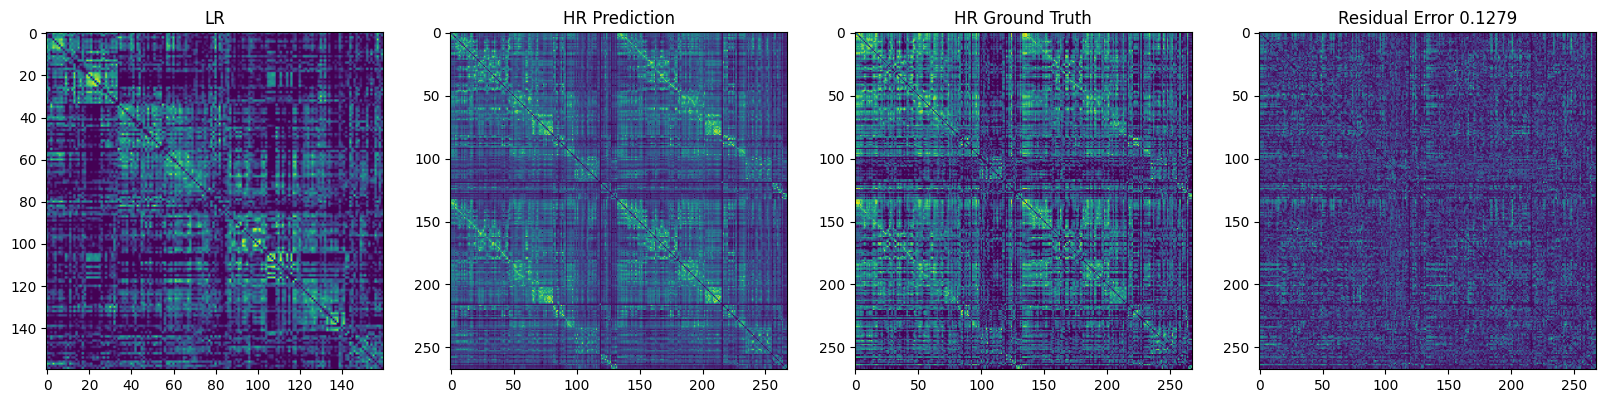

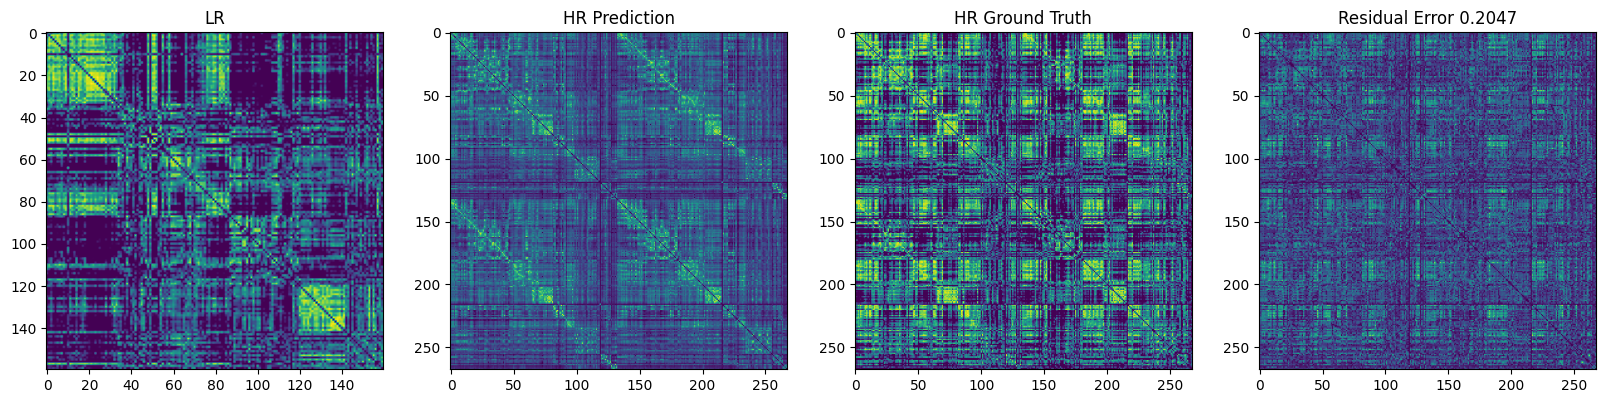

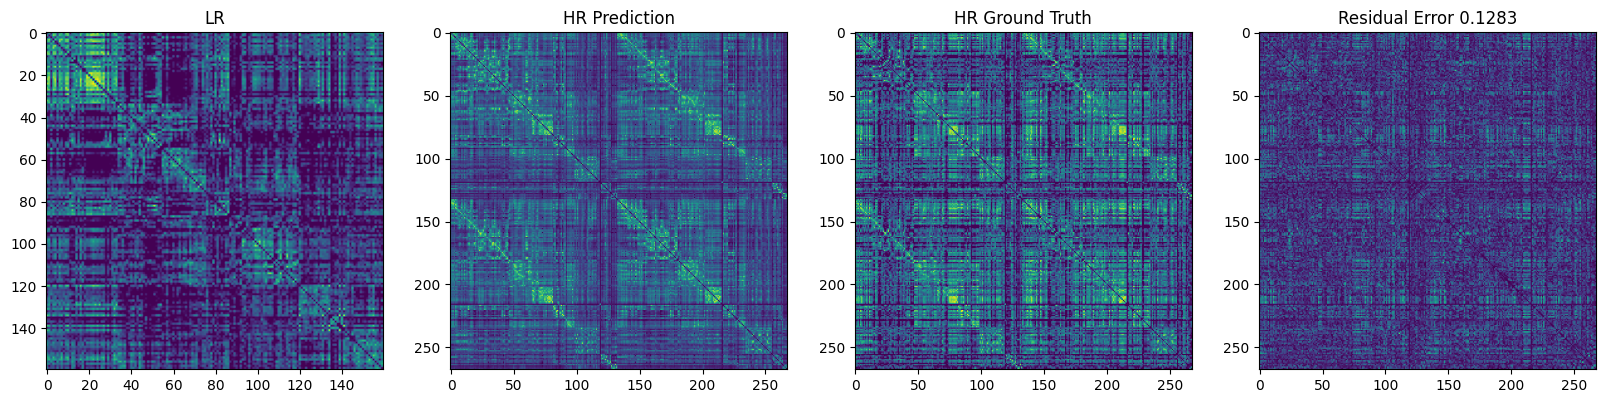

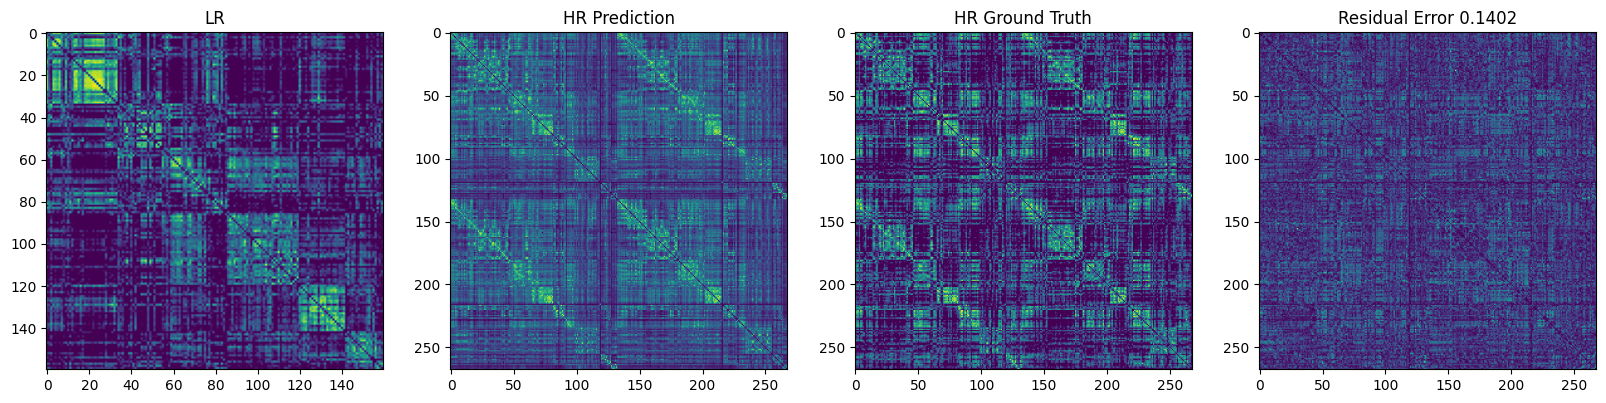

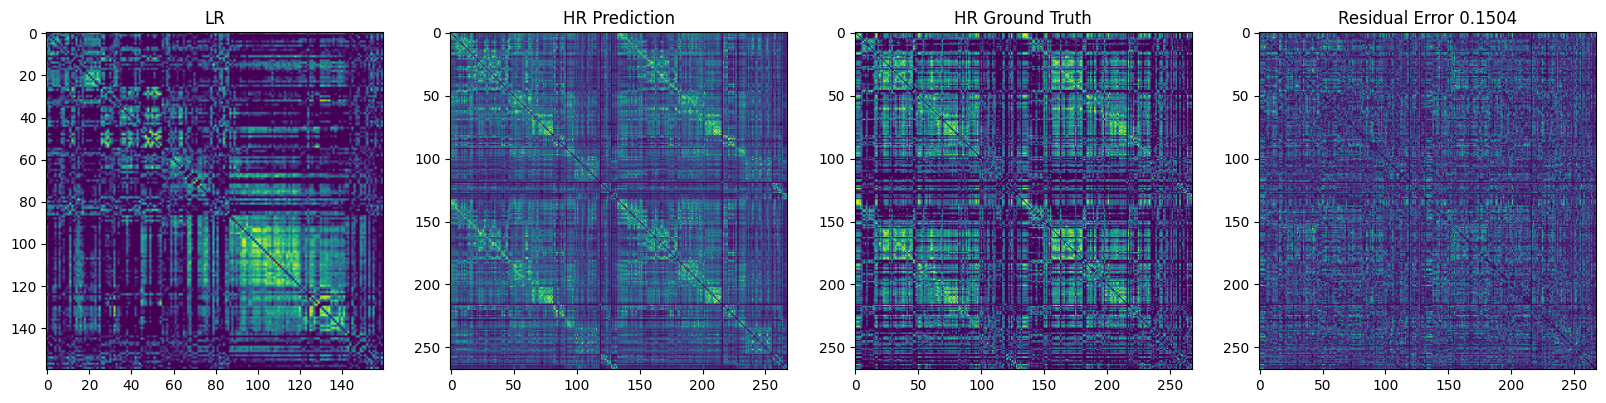

In [23]:
def compare_brain_connectivity_matrices(idx, lrs, hrs, model):
    """
    Visualization for the predictions vs the ground truth HR
    """
    hr_pred = unpad(model(lrs[idx])[0].detach().fill_diagonal_(0).numpy(), 26)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(lrs[idx])
    plt.title('LR')

    plt.subplot(1, 4, 2)
    plt.imshow(hr_pred)
    plt.title('HR Prediction')

    plt.subplot(1, 4, 3)
    plt.imshow(hrs[idx])
    plt.title('HR Ground Truth')

    plt.subplot(1, 4, 4)
    plt.imshow(abs(hrs[idx] - hr_pred))
    plt.title(f'Residual Error {torch.mean(abs(hrs[idx] - hr_pred)):.4f}')

    plt.show()

for i in range(5):
    compare_brain_connectivity_matrices(i, lr_train_tensor, hr_train_tensor, final_model)

In [24]:
# create_submission_csv(lr_test_tensor, final_model, "submission")